## This notebook compares Cosine-Gaussian signals generated with Burst Waveform and cWB MDC 

### Packages

In [3]:
import ROOT

include_path = "/cvmfs/software.igwn.org/conda/envs/igwn-py310-20240305/include"
wavelet_path = "/cvmfs/software.igwn.org/conda/envs/igwn-py310-20240305/lib/cwb.so"
ROOT.gInterpreter.AddIncludePath(include_path)
ROOT.gSystem.Load(wavelet_path)


1

In [4]:
import sys
import os
import numpy as np
sys.path.append(os.path.abspath('../'))
from burst_waveform.models import CosineGaussianQ
from matplotlib import pyplot as plt

from gwpy.timeseries import TimeSeries

### Function needed to have arrays (of the two differently generated signals) of the same lenght

In [5]:
def inject_burst_into_timeseries(burst_ts, target_ts, delay=0.0):
    # Ensure sample rates match
    if burst_ts.sample_rate != target_ts.sample_rate:
        raise ValueError("Sample rates of burst and target timeseries must match")
    
    sr = float(target_ts.sample_rate.value)  # Convert to plain float
    n_target = len(target_ts)
    
    # Calculate center position with delay
    center = n_target // 2 + int(delay * sr)
    
    n_burst = len(burst_ts)
    mid_burst = n_burst // 2
    
    # Calculate injection indices
    start = center - mid_burst
    end = start + n_burst

    # Check if burst fits
    if start < 0 or end > n_target:
        raise ValueError("Burst doesn't fit in target timeseries with given delay")
    
    # Create and return new timeseries with injected burst
    new_data = target_ts.value.copy()
    new_data[start:end] += burst_ts.value
    return TimeSeries(new_data, t0=target_ts.t0, sample_rate=sr, 
                     unit=target_ts.unit, name=f"{burst_ts.name}_injected_in_zeros_timeseries")


### Comparison

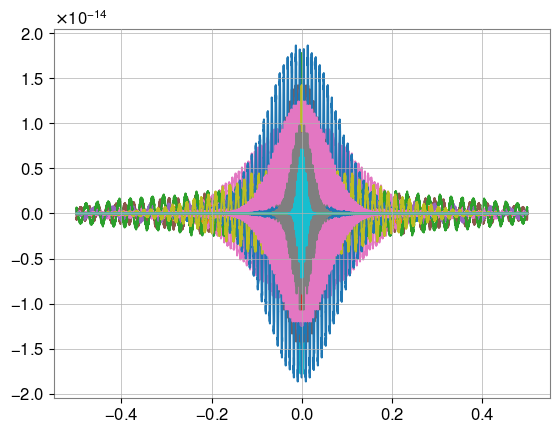

In [6]:
np.random.seed(42)
for i in range(200):
    frequency = np.random.uniform(10, 2000)
    Q = np.random.uniform(1,100)              # duration = Q / (2*pi*frequency)

    # Generate the burst with python burst waveform module
    params = {
        "amplitude": 1.0,
        "frequency": frequency,
        "Q": Q
    }
    model = CosineGaussianQ(params)
    cosine_gaussian_burst_waveform = model()

    # Creating a zeros timeseries in which inject the signal
    # (needed to compare the results of the python burst waveform module 
    # with the mdc cWB module)
    sample_rate = float(cosine_gaussian_burst_waveform.sample_rate.value)  # sample rate [Hz]
    inj_lenght = 1.  # Injenction lenght [s]
    num_samples = int(inj_lenght * sample_rate)  # Numero totale di campioni

    zeros_ts = TimeSeries(np.zeros(num_samples), t0=0.0, sample_rate=sample_rate, unit='cosine_gaussian_burst_waveform', name='zeros_timeseries_for_inj')

    # Inject the burst
    cosine_gaussian_burst_waveform_injected = inject_burst_into_timeseries(cosine_gaussian_burst_waveform, zeros_ts)
    
    MDC = ROOT.CWB.mdc()
    cosine_gaussian_cWB = MDC.GetCGQ(frequency, Q) 
    

    # Compute the difference between python and cWB generated waveform
    
    difference = cosine_gaussian_burst_waveform_injected.value - cosine_gaussian_cWB
    t = np.arange(-num_samples/2, num_samples/2) / sample_rate
    plt.plot(t,difference)


### Consistency Tests

#### 
The difference seems to be proportional to the offset between the parameters, i.e

\begin{equation} 
    frequency = value + offset\_frequency
    \nonumber
\end{equation}

\begin{equation} 
    Q = value + offset\_Q
    \nonumber
\end{equation}
then
\begin{equation}
    difference \propto max(offset\_frequency, offset\_Q)
    \nonumber
\end{equation}

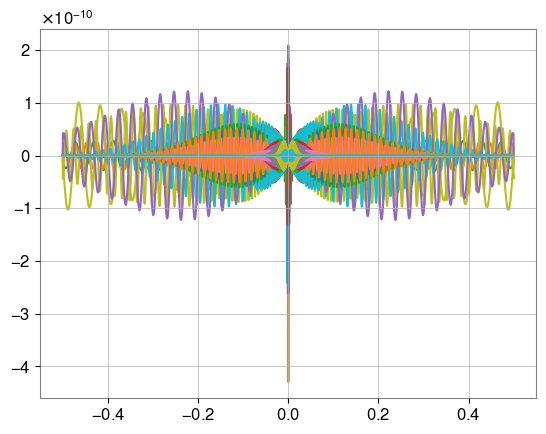

In [7]:
np.random.seed(42)
for i in range(200):
    frequency = np.random.uniform(10, 2000)
    Q = np.random.uniform(1,100)              # duration = Q / (2*pi*frequency)
    
    offset_frequency = np.random.uniform(-1e-10,1e-10)
    offset_Q = np.random.uniform(-1e-10,1e-10)

    # Generate the burst with python burst waveform module
    params = {
        "amplitude": 1.0,
        "frequency": frequency + offset_frequency,
        "Q": Q + offset_Q
    }
    model = CosineGaussianQ(params)
    cosine_gaussian_burst_waveform = model()

    # Creating a zeros timeseries in which inject the signal
    # (needed to compare the results of the python burst waveform module 
    # with the mdc cWB module)
    sample_rate = float(cosine_gaussian_burst_waveform.sample_rate.value)  # sample rate [Hz]
    inj_lenght = 1.  # Injenction lenght [s]
    num_samples = int(inj_lenght * sample_rate)  # Numero totale di campioni

    zeros_ts = TimeSeries(np.zeros(num_samples), t0=0.0, sample_rate=sample_rate, unit='cosine_gaussian_burst_waveform', name='zeros_timeseries_for_inj')

    # Inject the burst
    cosine_gaussian_burst_waveform_injected = inject_burst_into_timeseries(cosine_gaussian_burst_waveform, zeros_ts)
    
    MDC = ROOT.CWB.mdc()
    cosine_gaussian_cWB = MDC.GetCGQ(frequency, Q) 
    

    # Compute the difference between python and cWB generated waveform
    
    difference = cosine_gaussian_burst_waveform_injected.value - cosine_gaussian_cWB
    t = np.arange(-num_samples/2, num_samples/2) / sample_rate
    plt.plot(t,difference)